In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
os.listdir('./')

['.ipynb_checkpoints',
 'ex5.m',
 'ex5data1.mat',
 'featureNormalize.m',
 'fmincg.m',
 'learningCurve.m',
 'lib',
 'linearRegCostFunction.m',
 'plotFit.m',
 'polyFeatures.m',
 'submit.m',
 'trainLinearReg.m',
 'validationCurve.m',
 'Week6Exercise5.ipynb']

In [3]:
data = sio.loadmat('./ex5data1.mat')

In [4]:
X, y, Xval, yval, Xtest, ytest = map(np.ravel,[data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])

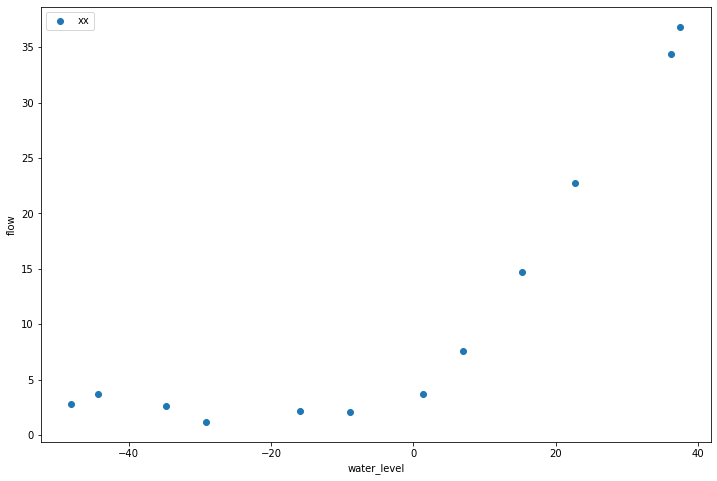

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X, y, label='xx')
ax.set_xlabel('water_level')
ax.set_ylabel('flow')
ax.legend()
plt.show()

# Regularized linear regression cost function

In [6]:
# 其中是正则化参数，他控制了正则化的程度。正则化项在原来的代价上加了一个惩罚项。随着参数的变大，惩罚项也会增大
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]


In [7]:
print(X)

[[  1.         -15.93675813]
 [  1.         -29.15297922]
 [  1.          36.18954863]
 [  1.          37.49218733]
 [  1.         -48.05882945]
 [  1.          -8.94145794]
 [  1.          15.30779289]
 [  1.         -34.70626581]
 [  1.           1.38915437]
 [  1.         -44.38375985]
 [  1.           7.01350208]
 [  1.          22.76274892]]


In [51]:
def cost(theta, X, y):
    """
    X: R(m*n), m records, n features
    y: R(m)
    theta : R(n), linear regression parameters
    """
    
#     m represent records numbers 
    m = X.shape[0]

    inner = X @ theta - y  # R(m*1)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [52]:
def costReg(theta, X, y, reg = 1):
    
    m = X.shape[0]

    regularized_term = (reg / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [10]:
theta = np.ones(X.shape[1])
# theta 是竖着的向量， 2行1列


In [11]:
costReg(theta, X, y, 1)

303.9931922202643

# 1.3 Regularized linear regression gradient

In [12]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)

    return inner / m

In [13]:
def gradientReg(theta, X, y, reg):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta

    regularized_term = (reg / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [14]:
gradientReg(theta, X, y, 1)

array([-15.30301567, 598.25074417])

# 1.4 Fitting linear regression

In [15]:
# 用工具库找到最优解，在这个部分，我们令lambda=0。因为我们现在训练的是2维的theta，所以正则化不会对这种低维的theta有很大的帮助。 完成之后，将数据和拟合曲线可视化。
theta = np.ones(X.shape[1])
# theta为2*1 的vector，因为theta是根据数据的Features来的（X的个数）
final_theta = opt.minimize(fun=costReg, x0=theta, args=(X, y, 0), method='TNC', jac=gradientReg, options={'disp': True}).x
final_theta

array([13.08790348,  0.36777923])

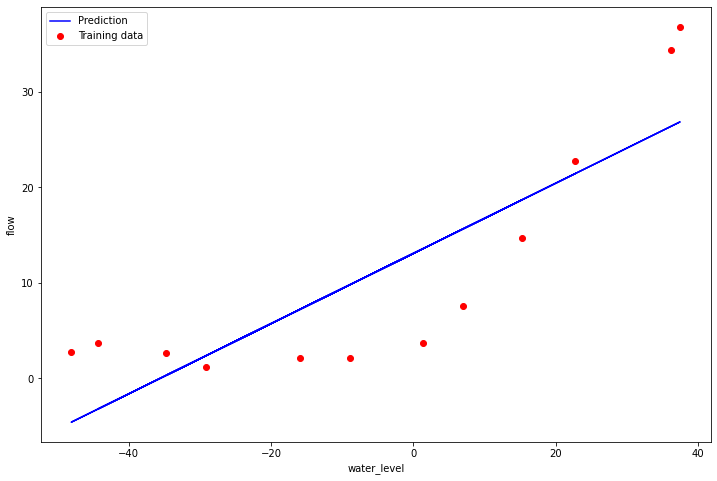

In [16]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(X[:,1], y, c='r', label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, c='b', label="Prediction")
ax.set_xlabel('water_level')
ax.set_ylabel('flow')
ax.legend()
plt.show()

# 2 Bias-variance

## 2.1 Learning curves

In [46]:
# 机器学习中的一个重要概念是偏差-方差权衡。偏差较大的模型会欠拟合，而方差较大的模型会过拟合。这部分会让你画出学习曲线来判断方差和偏差的问题。
# 1.使用训练集的子集来拟合应模型 
# 2.在计算训练代价和验证集代价时，没有用正则化 
# 3.记住使用相同的训练集子集来计算训练代价 代价公式为：
def linear_regression(X, y, l=1):
    """linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.ones(X.shape[1])

    # train it
    res = opt.minimize(fun=costReg,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=gradientReg,
                       options={'disp': True})
    return res

In [60]:
training_cost, cv_cost = [], []

In [61]:
# m records
m = X.shape[0]
for i in range(1, m +1):
    res = linear_regression(X[:i, :], y[:i], 0)
    
    tc = costReg(res.x, X[:i, :], y[:i], 0)
    cv = costReg(res.x, Xval, yval, 0)
    
    training_cost.append(tc)
    cv_cost.append(cv)
    

In [62]:
print(len(training_cost))
print(len(cv_cost))

12
12


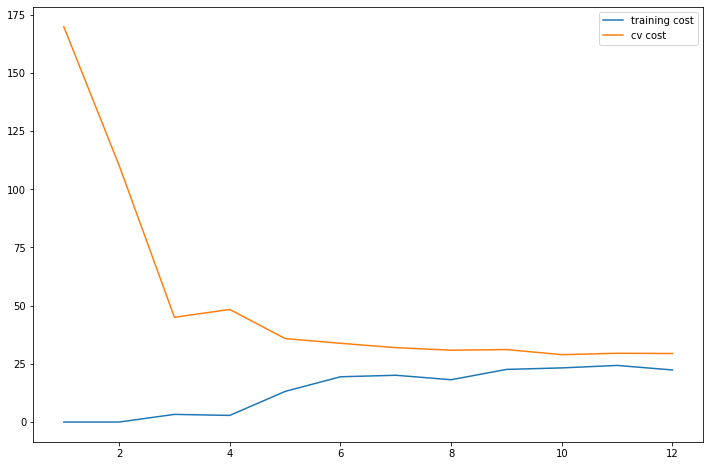

In [63]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend()
plt.show()

# 3 Polynomial regression

In [43]:
i = 1
X[:1 , :]
res = linear_regression(X[:1], y[:1])
res.x
# 函数得到的x数组，实则是theta，分别针对x0， x1

array([ 2.13424969e+00, -3.80099066e-06])

In [23]:
test = np.ones(X.shape[1])
test

AttributeError: module 'numpy' has no attribute 'one'

In [17]:
array1 = [[1,2,3,],[3,4,5]]

In [18]:
matrix1 = np.mat(array1)
matrix1

matrix([[1, 2, 3],
        [3, 4, 5]])

In [19]:
matrix1.T

matrix([[1, 3],
        [2, 4],
        [3, 5]])